In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
tf.config.list_physical_devices('GPU')
import plotly.io as pio
import os
import shutil
import plotly.graph_objs as go
from ipywidgets import Output, VBox
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense,Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

TensorFlow version: 2.12.0


In [2]:
#pip install -U kaleido PyPDF2

In [3]:
csv = pd.read_csv('./pda_2023-04-18_10-13-22.csv', skiprows = 7)
csv['Zeit'] =  pd.to_datetime(csv['Zeit'])
csv.sort_values(by='Zeit', inplace = True)
df = csv[['Zeit','product_id', 'run_id', 'experiment_id', 'trial_id', 'set_force_begin',
       'x_position', 'y_position', 'z1_position', 'z2_position', 'x_velocity',
       'y_velocity', 'z1_velocity', 'z2_velocity', 'x_force', 'y_force',
       'z_force']]
df = df[df["product_id"] == 304]
df = df[df["run_id"] == 0]
df = df[df["experiment_id"] == 0]
df["trial_id"].unique()
labels = pd.read_csv('../labels_030723.csv')
print(len(labels))

400


In [4]:
labels = labels[labels['row'] == 'Aussortieren']
len(labels)

2

# Load Training Sensor Data

In [5]:
csv = pd.read_csv('./pda_2023-04-18_10-13-22.csv', skiprows = 7)
csv['Zeit'] =  pd.to_datetime(csv['Zeit'])
csv.sort_values(by='Zeit', inplace = True)

labels = pd.read_csv('./labels_030723.csv')
labels = labels[labels['row'] != 'None']
labels = labels[labels['row'] != 'Aussortieren']
print(len(labels))

df = csv[['Zeit','product_id', 'run_id', 'experiment_id', 'trial_id', 'set_force_begin',
       'x_position', 'y_position', 'z1_position', 'z2_position', 'x_velocity',
       'y_velocity', 'z1_velocity', 'z2_velocity', 'x_force', 'y_force',
       'z_force']]
df = df[df["product_id"] == 304]
good_experiment_ids = [{"run_id": 0, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
                  {"run_id": 1, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
                  {"run_id": 2, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
                  {"run_id": 3, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}
                ]
peak_dfs = []
i = 0
for item in good_experiment_ids:
    df_temp = df[df["run_id"] == item["run_id"]]
    for item2 in item["experiment_ids"]:
        df_temp2 = df_temp[df_temp["experiment_id"] == item2]
        liste_temp = df_temp2["trial_id"].unique()
        for item3 in liste_temp:
            i += 1
            #print(item["run_id"], item2, item3 )
            if labels[(labels['trial_id'] == item3) & (labels['experiment_id'] == item2) & (labels['run_id'] == item["run_id"])].shape[0] > 0:
                peak_df = df_temp2[df_temp2["trial_id"] == item3]
                peak_dfs.append(peak_df[["run_id", "trial_id", "experiment_id", 'x_position', 'x_force', 'y_force', 'z_force']])
                
print(len(peak_dfs))

filtered_peak_dfs = []

for i, item in enumerate(peak_dfs):
    filtered_df_temp = item[item['x_position'] > 20.0001].reset_index(drop=True)
    
    peak_row_temp = filtered_df_temp['x_position'].idxmax()
    
    peak_row_data_temp = filtered_df_temp.loc[:peak_row_temp-1]
    
    filtered_df_temp2 = filtered_df_temp.loc[peak_row_temp:]
    
    condition = filtered_df_temp2['x_force'] >= 0
    
    extracted_rows = filtered_df_temp2.loc[:condition.idxmax()]
        
    if (extracted_rows['x_position'] >= 99.9).all():
        filtered_peak_dfs.append(pd.concat([peak_row_data_temp, extracted_rows]))
    else:
        filtered_peak_dfs.append(peak_row_data_temp)
print(len(filtered_peak_dfs))

max_length = max(len(df) for df in filtered_peak_dfs)

padded_dataframes = []
for df in filtered_peak_dfs:
    padding_size = 519 - len(df) #padding_size - len(df) # check classification
    padded_df = pd.DataFrame(np.pad(df.values, ((0, padding_size), (0, 0)), mode='edge'), columns=df.columns)
    padded_df['index'] = padded_df.index
    padded_dataframes.append(padded_df)
print(len(padded_dataframes))

lengths = set()
polke_padded_dataframes_with_labels = []
for item in padded_dataframes:
    lengths.add(len(item))
    
    run_id = item["run_id"].unique()[0],
    trial_id = item["trial_id"].unique()[0],
    experiment_id = item["experiment_id"].unique()[0]
    
    #print("RUN_ID:", run_id,"experiment_id:",  experiment_id,"trial_id:", trial_id)

    indidvidual = labels[labels["run_id"] == run_id]
    indidvidual = indidvidual[indidvidual["experiment_id"] == experiment_id]
    indidvidual = indidvidual[indidvidual["trial_id"] == trial_id]
    
    if indidvidual['row'].iloc[0].isnumeric():
        row_value = int(indidvidual['row'])
        polke_padded_dataframes_with_labels.append((item, row_value))
    else:
        continue
print(lengths)

255
255
255
255
{519}


In [6]:
polke_padded_dataframes_with_labels[3][0]

run_id  trial_id  experiment_id  x_position    x_force   y_force  \
0       0.0       3.0            0.0   20.001136   0.016116 -0.018481   
1       0.0       3.0            0.0   20.001136   0.016116 -0.018481   
2       0.0       3.0            0.0   20.000925   0.020804 -0.025105   
3       0.0       3.0            0.0   20.000925   0.020804 -0.025105   
4       0.0       3.0            0.0   20.000983   0.011951 -0.019423   
..      ...       ...            ...         ...        ...       ...   
514     0.0       3.0            0.0   99.965557 -10.445413  0.315742   
515     0.0       3.0            0.0   99.965557 -10.445413  0.315742   
516     0.0       3.0            0.0   99.965557 -10.445413  0.315742   
517     0.0       3.0            0.0   99.965557 -10.445413  0.315742   
518     0.0       3.0            0.0   99.965557 -10.445413  0.315742   

       z_force  index  
0     0.012018      0  
1     0.012018      1  
2    -0.001441      2  
3    -0.001441      3  
4     0.014466      4  
..         ...    ...  
514  23.306080    514  
515  23.306080    515  
516  23.306080    516  
517  23.306080    517  
518  23.306080    518  

[519 rows x 8 columns]

300


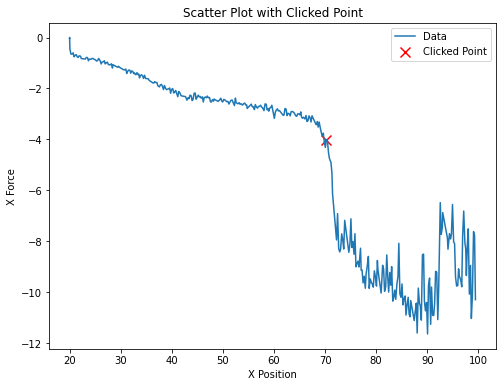

In [7]:
random_number = random.randint(0, len(polke_padded_dataframes_with_labels) - 1)
df_show = polke_padded_dataframes_with_labels[random_number][0]
label = polke_padded_dataframes_with_labels[random_number][1]
print(label)

plt.figure(figsize=(8, 6))

# Plotting the lines
plt.plot(df_show["x_position"], df_show["x_force"], linestyle='-', label='Data')

# Get the target row based on the label
target_row = df_show.iloc[label]

# Plot the clicked point as a red 'X'
plt.scatter(target_row["x_position"], target_row["x_force"], color='red', marker='x', s=100, label='Clicked Point')

plt.xlabel('X Position')
plt.ylabel('X Force')
plt.title('Scatter Plot with Clicked Point')
plt.legend()
plt.show()

# Test it

In [8]:
padded_dataframes_with_labels_combined = polke_padded_dataframes_with_labels

print(len(padded_dataframes_with_labels_combined))

255


In [9]:
random_number = random.randint(0, len(padded_dataframes_with_labels_combined))
df_show = padded_dataframes_with_labels_combined[random_number][0]
label = padded_dataframes_with_labels_combined[random_number][1]
print(label)
fig = go.Figure(data=go.Scatter(x=df_show["x_position"], y=df_show["x_force"], mode='lines'))

# Get the row at the given index using iloc
target_row = df_show.iloc[label]

# Create a new scatter trace with the clicked point as a red tick marker
clicked_point = go.Scatter(
    x=np.array(target_row["x_position"]),
    y=np.array(target_row["x_force"]),
    mode='markers',
    marker=dict(
        symbol='x',
        size=10,
        color='red'))

# Add the new scatter trace to the figure
fig.add_trace(clicked_point)
fig.show()

366


# ML

In [10]:
#padded_dataframes_with_labels_combined[1][0]

In [11]:
tensor_X = []
tensor_y = []
for item in padded_dataframes_with_labels_combined:
    #df_temp = item[0][['x_force', 'y_force', 'z_force']].copy()
    #df_temp = item[0][['x_force', 'z_force']].copy()
    df_temp = item[0][['x_force']].copy()
    a = df_temp.to_numpy().astype(np.float32)
    tensor_X.append(a)
    tensor_y.append(item[1])
print(len(tensor_X))
print(len(tensor_y))

# train test split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(tensor_X), np.array(tensor_y), test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.9, shuffle=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape , y_val.shape)

255
255
(204, 519, 1) (46, 519, 1) (204,) (46,) (5, 519, 1) (5,)


In [12]:
# random_number = random.randint(0, len(tensor_X))

# data=tensor_X[random_number]
# y = tensor_y[random_number]

# if len(data.shape) > 1:
#     yo = data[:, 0]
# else:
#     yo = data.flatten()

# fig = go.Figure(data=go.Scatter(x=np.arange(len(yo)), y=yo, mode='lines'))

# # Create a new scatter trace with the clicked point as a red tick marker
# clicked_point = go.Scatter(
#     x=np.array(y),
#     y=np.array(data[y]),
#     mode='markers',
#     marker=dict(
#         symbol='x',
#         size=10,
#         color='red'
#     )
# )
# # Add the new scatter trace to the figure
# fig.add_trace(clicked_point)

# fig.show()

In [13]:
# ### check training data
# random_number = random.randint(0, len(X_train))
# if len(X_train[random_number].shape) > 1:
#     yo = X_train[random_number][:, 0]
# else:
#     yo = X_train[random_number].flatten()
    
# fig = go.Figure(data=go.Scatter(x=np.arange(len(yo)), y=yo, mode='lines'))

# # Create a new scatter trace with the clicked point as a red tick marker
# clicked_point = go.Scatter(
#     x=np.array(int(y_train[random_number])),
#     y=np.array(X_train[random_number][int(y_train[random_number])]),
#     mode='markers',
#     marker=dict(
#         symbol='x',
#         size=10,
#         color='red'
#     )
# )
# # Add the new scatter trace to the figure
# fig.add_trace(clicked_point)
# fig.show()

In [14]:
# ### check test data
# random_number = random.randint(0, len(X_test))
# if len(X_test[random_number].shape) > 1:
#     yo = X_test[random_number][:, 0]
# else:
#     yo = X_test[random_number].flatten()
    
# print(np.array(int(y_test[random_number])))
# print(data[int(y_test[random_number])])
# fig = go.Figure(data=go.Scatter(x=np.arange(len(yo)), y=yo, mode='lines'))

# # Create a new scatter trace with the clicked point as a red tick marker
# clicked_point = go.Scatter(
#     x=np.array(int(y_test[random_number])),
#     y=np.array(X_test[random_number][int(y_test[random_number])]),
#     mode='markers',
#     marker=dict(
#         symbol='x',
#         size=10,
#         color='red'
#     )
# )
# # Add the new scatter trace to the figure
# fig.add_trace(clicked_point)

# fig.show()

# Regression

In [15]:
random_number = random.randint(0, len(X_train)-1)
print(X_train[random_number].shape[0])
print(X_train[random_number].shape)
X_train[random_number].shape[1]

519
(519, 1)


1

In [16]:
# Define the model architecture
model = Sequential()
kernel_size = 4

random_number = random.randint(0, len(tensor_X))

# Add normalization layer
model.add(BatchNormalization(input_shape=(519, 1)))

model.add(Conv1D(8, kernel_size=kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(16, kernel_size=kernel_size*2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, kernel_size=kernel_size*4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Adjust the learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer, loss='mean_squared_error')

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'Polke_only_Regression_best_model.h5',              # Filepath to save the model
    monitor='val_loss',           # Metric to monitor
    save_best_only=True,          # Save only the best model
    save_weights_only=False,      # Save the entire model (including architecture)
    mode='min',                   # 'min' or 'max' depending on the monitored metric
    verbose=1                      # Print messages about saving progress
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/200
13/13 [==============================] - ETA: 0s - loss: 118438.6094
Epoch 1: val_loss improved from inf to 30068.23438, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 2s 44ms/step - loss: 118438.6094 - val_loss: 30068.2344
Epoch 2/200
13/13 [==============================] - ETA: 0s - loss: 31158.3594
Epoch 2: val_loss improved from 30068.23438 to 28656.33203, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 0s 24ms/step - loss: 31158.3594 - val_loss: 28656.3320
Epoch 3/200
13/13 [==============================] - ETA: 0s - loss: 10454.2393
Epoch 3: val_loss improved from 28656.33203 to 20178.90234, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 0s 25ms/step - loss: 10454.2393 - val_loss: 20178.9023
Epoch 4/200
13/13 [==============================] - ETA: 0s - loss: 5888.1943
Epoch 4: val_loss did not improve from 20178.90234
13/13 [=====

Epoch 33/200
13/13 [==============================] - ETA: 0s - loss: 1060.8359
Epoch 33: val_loss improved from 917.45813 to 890.44226, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 0s 25ms/step - loss: 1060.8359 - val_loss: 890.4423
Epoch 34/200
12/13 [==========================>...] - ETA: 0s - loss: 1069.7882
Epoch 34: val_loss did not improve from 890.44226
13/13 [==============================] - 0s 21ms/step - loss: 1056.8661 - val_loss: 1159.2014
Epoch 35/200
13/13 [==============================] - ETA: 0s - loss: 1163.7979
Epoch 35: val_loss did not improve from 890.44226
13/13 [==============================] - 0s 20ms/step - loss: 1163.7979 - val_loss: 935.2343
Epoch 36/200
13/13 [==============================] - ETA: 0s - loss: 965.9485
Epoch 36: val_loss improved from 890.44226 to 888.42792, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 0s 24ms/step - loss: 965.9485 - val_loss: 

13/13 [==============================] - 0s 24ms/step - loss: 444.7158 - val_loss: 194.7832
Epoch 67/200
13/13 [==============================] - ETA: 0s - loss: 563.5380
Epoch 67: val_loss did not improve from 194.78322
13/13 [==============================] - 0s 18ms/step - loss: 563.5380 - val_loss: 218.4118
Epoch 68/200
10/13 [======================>.......] - ETA: 0s - loss: 441.7932
Epoch 68: val_loss improved from 194.78322 to 178.90413, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 0s 23ms/step - loss: 503.9297 - val_loss: 178.9041
Epoch 69/200
13/13 [==============================] - ETA: 0s - loss: 699.8050
Epoch 69: val_loss did not improve from 178.90413
13/13 [==============================] - 0s 18ms/step - loss: 699.8050 - val_loss: 850.4079
Epoch 70/200
10/13 [======================>.......] - ETA: 0s - loss: 967.1176
Epoch 70: val_loss did not improve from 178.90413
13/13 [==============================] - 0s 18ms/step - l

13/13 [==============================] - 0s 18ms/step - loss: 346.0194 - val_loss: 296.1938
Epoch 103/200
13/13 [==============================] - ETA: 0s - loss: 413.3914
Epoch 103: val_loss did not improve from 116.96857
13/13 [==============================] - 0s 18ms/step - loss: 413.3914 - val_loss: 266.6926
Epoch 104/200
10/13 [======================>.......] - ETA: 0s - loss: 211.1781
Epoch 104: val_loss did not improve from 116.96857
13/13 [==============================] - 0s 18ms/step - loss: 217.5958 - val_loss: 181.7909
Epoch 105/200
13/13 [==============================] - ETA: 0s - loss: 337.3152
Epoch 105: val_loss did not improve from 116.96857
13/13 [==============================] - 0s 18ms/step - loss: 337.3152 - val_loss: 575.4245
Epoch 106/200
13/13 [==============================] - ETA: 0s - loss: 525.3535
Epoch 106: val_loss did not improve from 116.96857
13/13 [==============================] - 0s 18ms/step - loss: 525.3535 - val_loss: 256.3044
Epoch 107/200
13

Epoch 139/200
13/13 [==============================] - ETA: 0s - loss: 310.2915
Epoch 139: val_loss did not improve from 80.59152
13/13 [==============================] - 0s 18ms/step - loss: 310.2915 - val_loss: 234.2276
Epoch 140/200
13/13 [==============================] - ETA: 0s - loss: 145.3790
Epoch 140: val_loss did not improve from 80.59152
13/13 [==============================] - 0s 18ms/step - loss: 145.3790 - val_loss: 98.6942
Epoch 141/200
10/13 [======================>.......] - ETA: 0s - loss: 141.4611
Epoch 141: val_loss improved from 80.59152 to 78.66798, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 1s 44ms/step - loss: 143.5064 - val_loss: 78.6680
Epoch 142/200
13/13 [==============================] - ETA: 0s - loss: 185.3290
Epoch 142: val_loss did not improve from 78.66798
13/13 [==============================] - 0s 18ms/step - loss: 185.3290 - val_loss: 405.2785
Epoch 143/200
 9/13 [===================>..........] - E

10/13 [======================>.......] - ETA: 0s - loss: 217.3909
Epoch 175: val_loss did not improve from 58.85823
13/13 [==============================] - 0s 17ms/step - loss: 200.8204 - val_loss: 98.1550
Epoch 176/200
13/13 [==============================] - ETA: 0s - loss: 109.8444
Epoch 176: val_loss improved from 58.85823 to 54.94022, saving model to Polke_only_Regression_best_model.h5
13/13 [==============================] - 0s 24ms/step - loss: 109.8444 - val_loss: 54.9402
Epoch 177/200
13/13 [==============================] - ETA: 0s - loss: 96.8158 
Epoch 177: val_loss did not improve from 54.94022
13/13 [==============================] - 0s 17ms/step - loss: 96.8158 - val_loss: 115.3197
Epoch 178/200
13/13 [==============================] - ETA: 0s - loss: 134.5758
Epoch 178: val_loss did not improve from 54.94022
13/13 [==============================] - 0s 18ms/step - loss: 134.5758 - val_loss: 147.9526
Epoch 179/200
13/13 [==============================] - ETA: 0s - loss: 

In [19]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)
# Print the evaluation result
print("Loss: ", loss)

# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines', name='Validation Loss'))
fig.update_layout(title='Loss', xaxis_title='Epochs', yaxis_title='Loss')
fig.show()

2/2 [==============================] - 0s 12ms/step - loss: 652.0077
Loss:  652.0076904296875


In [20]:
best_model = tf.keras.models.load_model('Polke_only_Regression_best_model.h5')
# Evaluate the model on the test data
loss = best_model.evaluate(X_test, y_test)
# Print the evaluation result
print("Loss: ", loss)

2/2 [==============================] - 0s 11ms/step - loss: 695.7324
Loss:  695.7323608398438


2/2 [==============================] - 0s 8ms/step


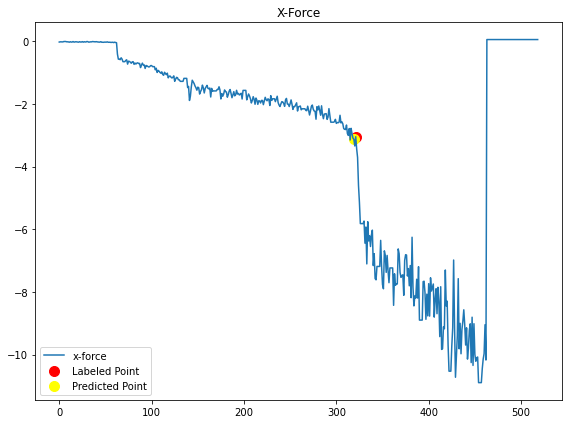

##################### NEXT #####################


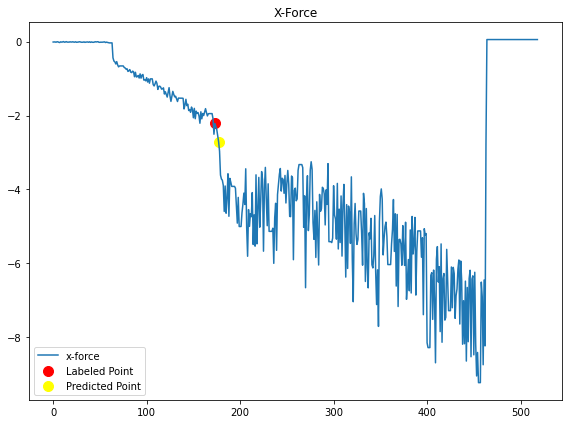

##################### NEXT #####################


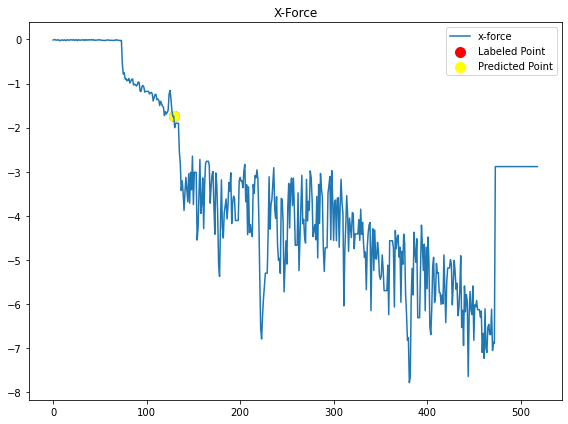

##################### NEXT #####################


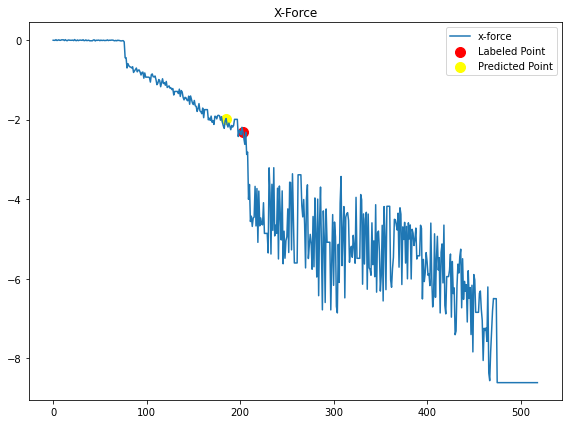

##################### NEXT #####################


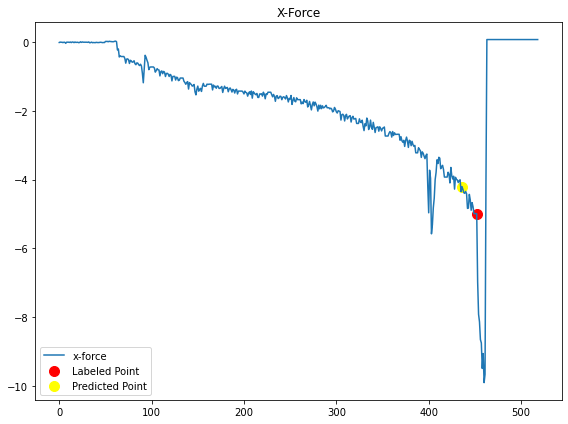

##################### NEXT #####################


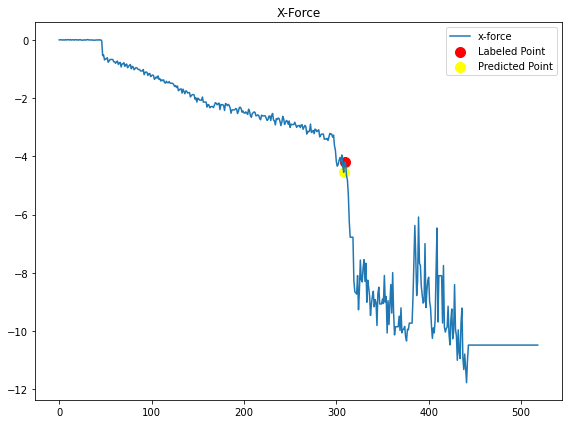

##################### NEXT #####################


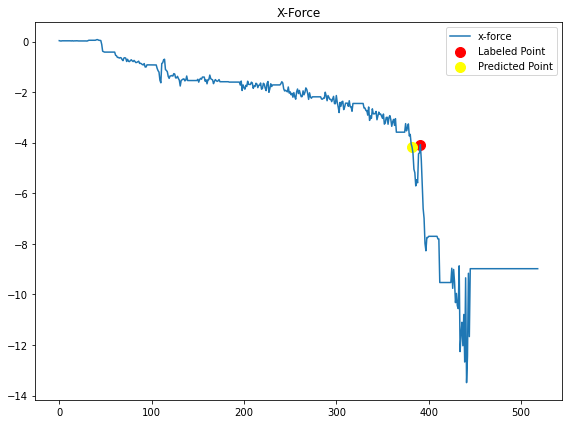

##################### NEXT #####################


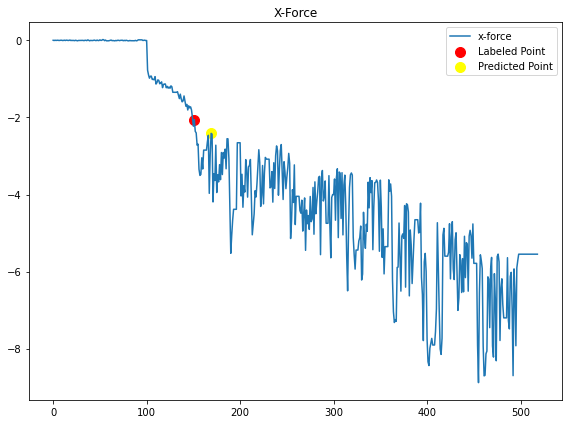

##################### NEXT #####################


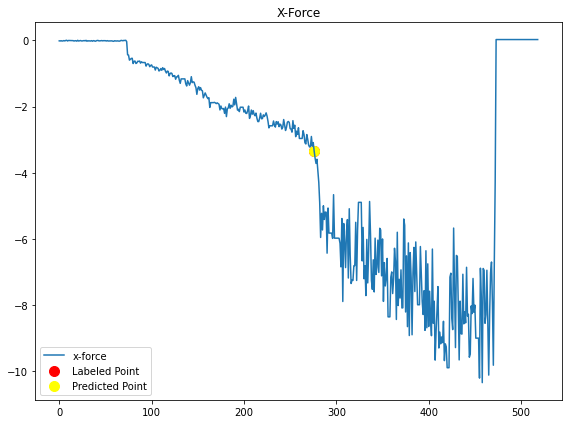

##################### NEXT #####################


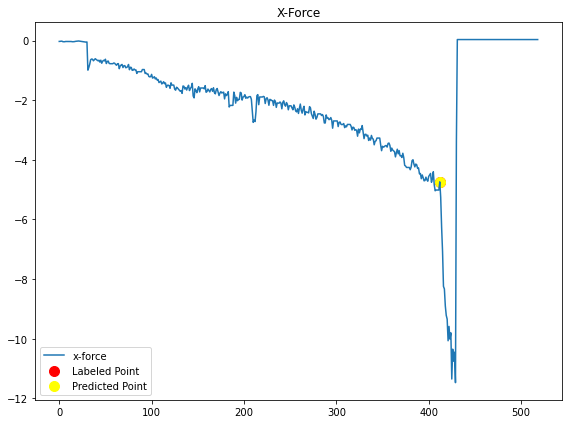

##################### NEXT #####################


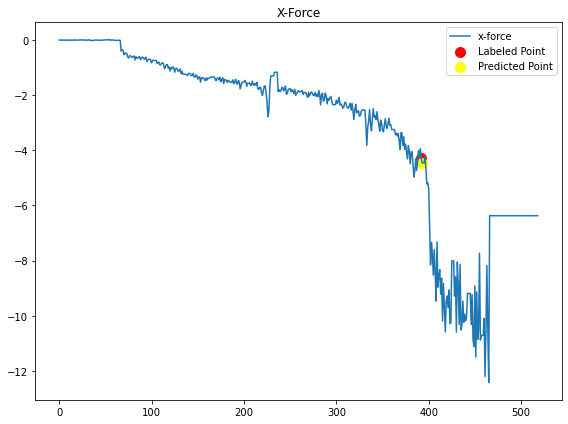

##################### NEXT #####################


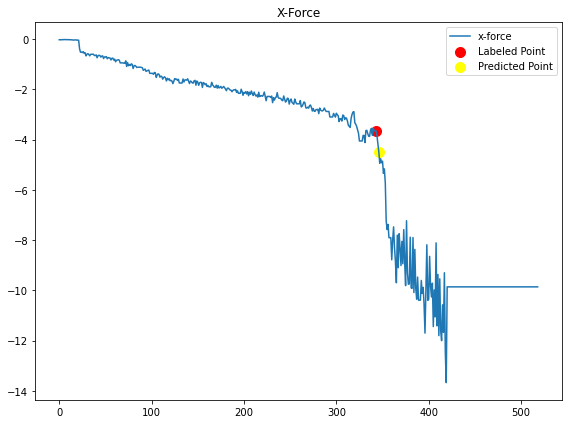

##################### NEXT #####################


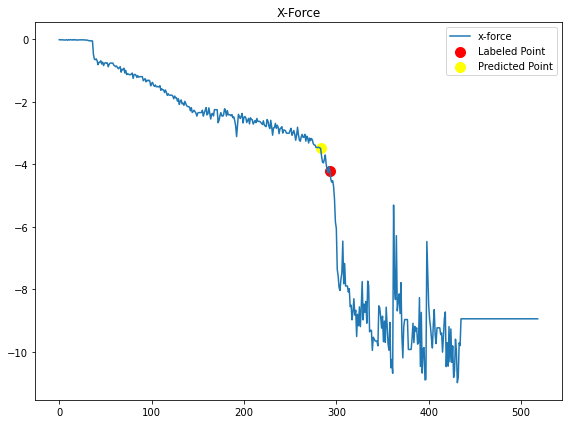

##################### NEXT #####################


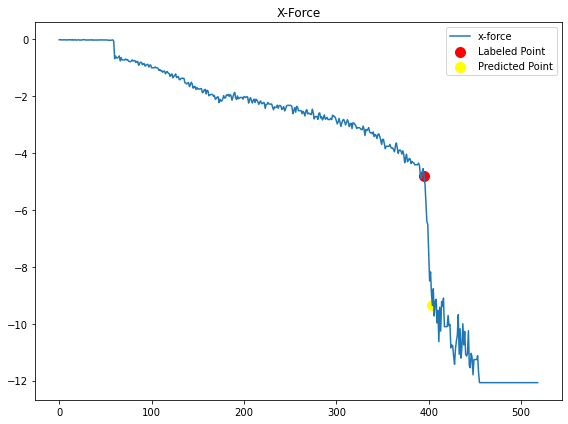

##################### NEXT #####################


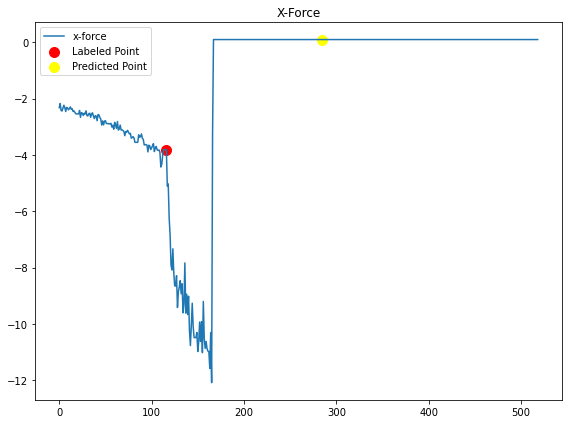

##################### NEXT #####################


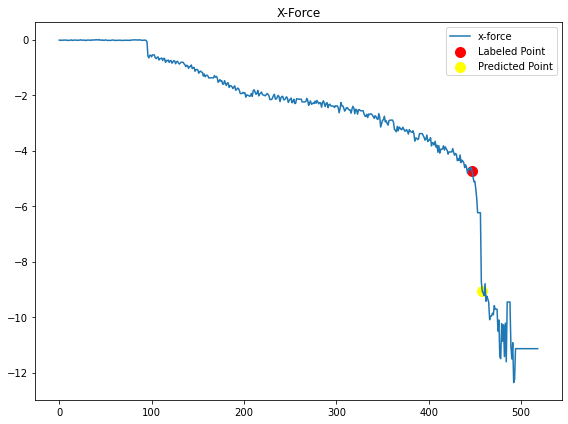

##################### NEXT #####################


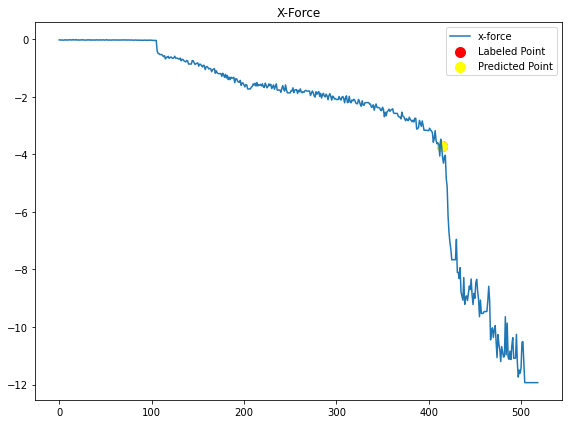

##################### NEXT #####################


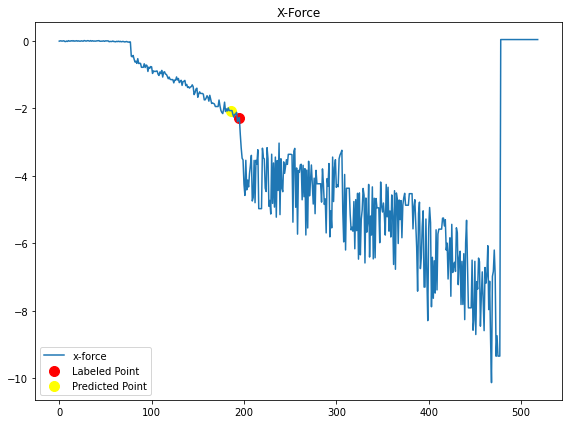

##################### NEXT #####################


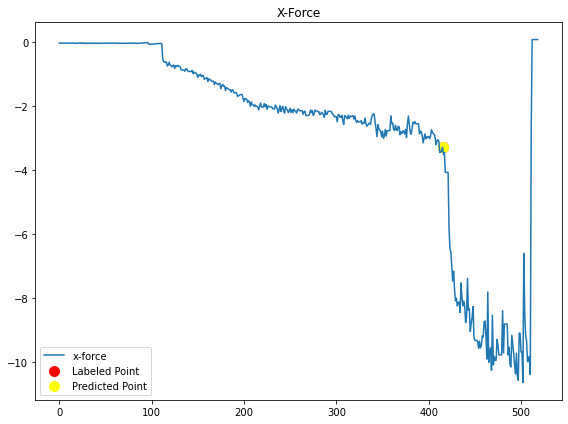

##################### NEXT #####################


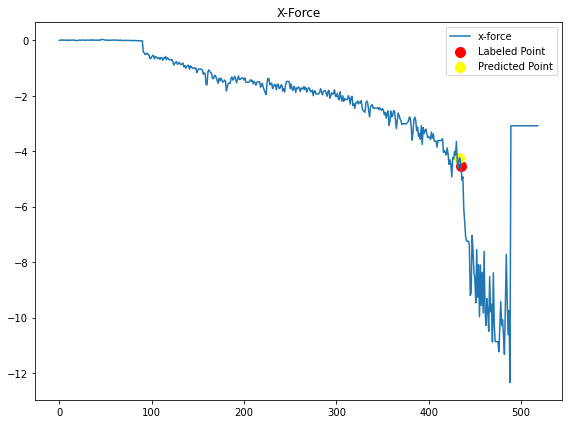

##################### NEXT #####################


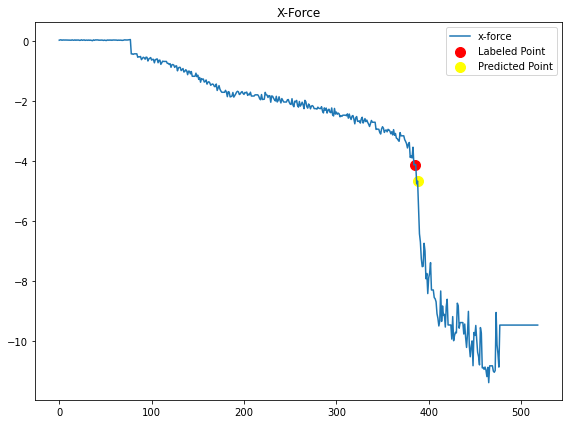

##################### NEXT #####################


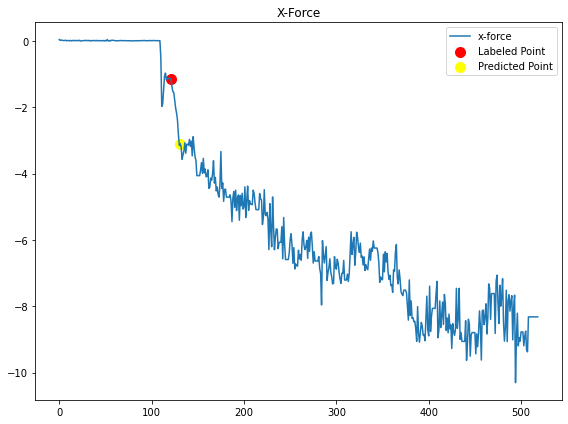

##################### NEXT #####################


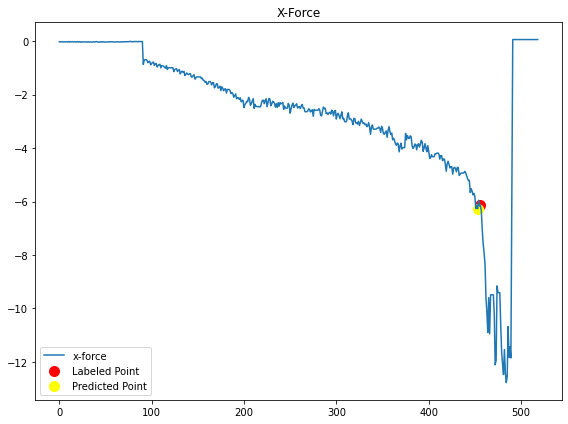

##################### NEXT #####################


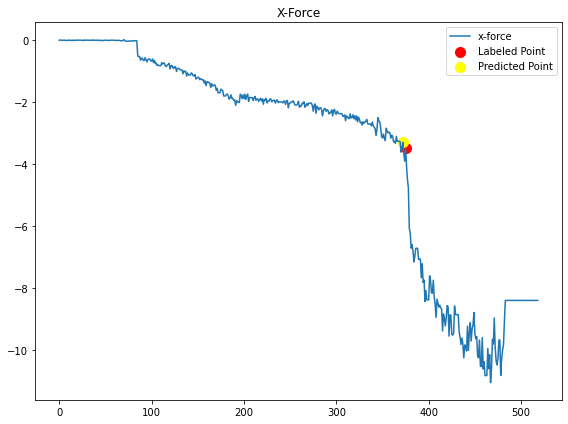

##################### NEXT #####################


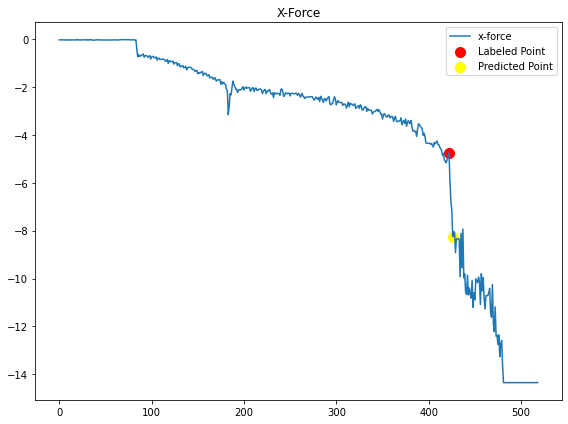

##################### NEXT #####################


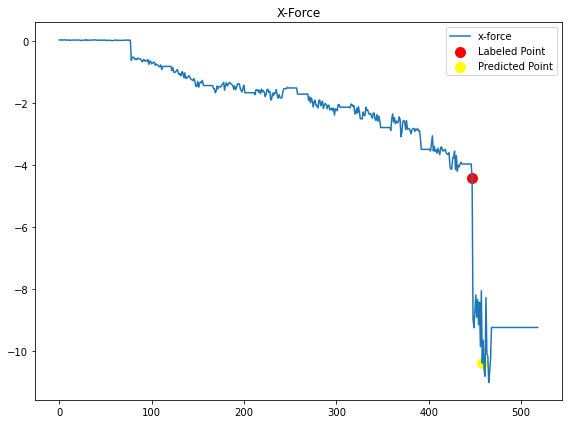

##################### NEXT #####################


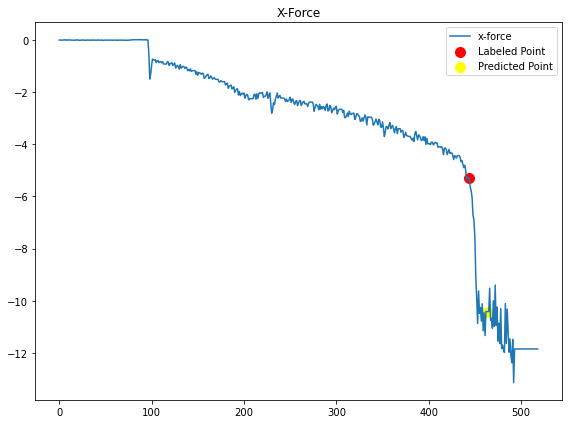

##################### NEXT #####################


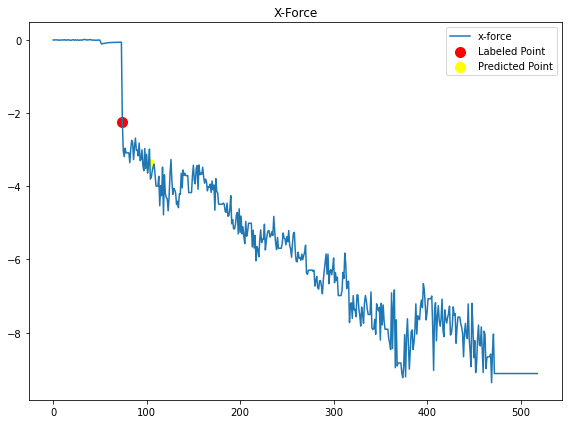

##################### NEXT #####################


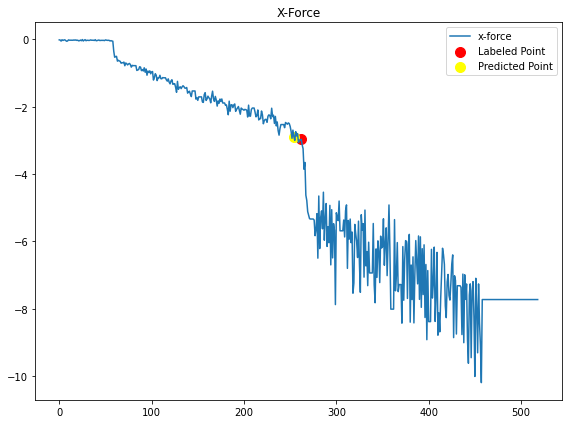

##################### NEXT #####################


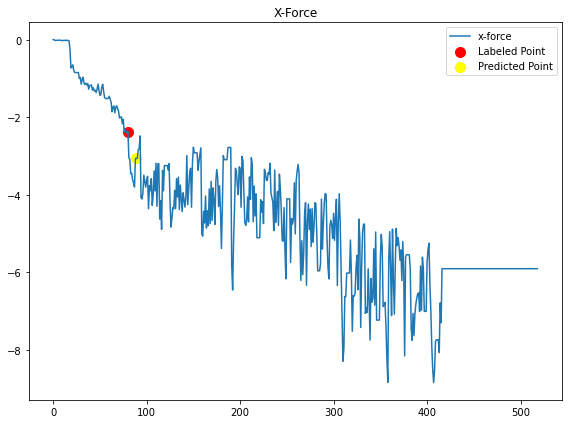

##################### NEXT #####################


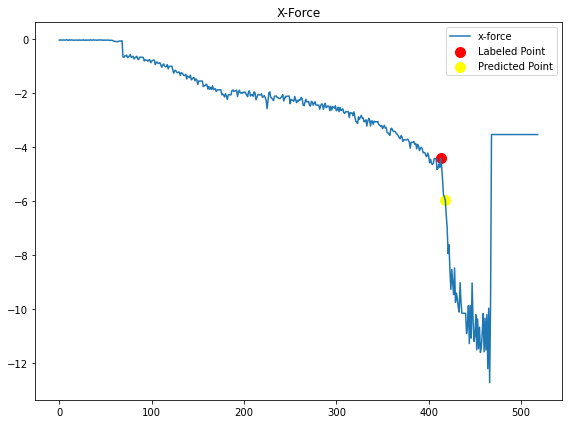

##################### NEXT #####################


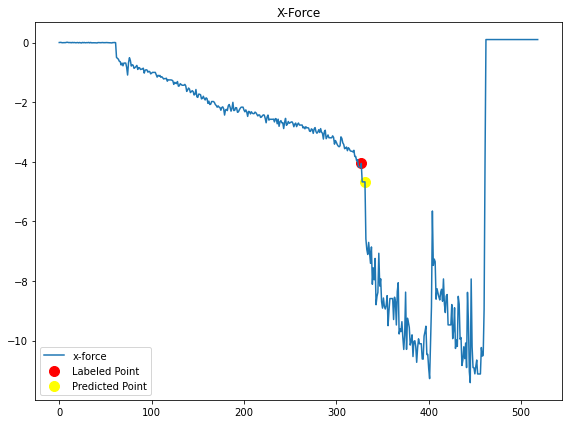

##################### NEXT #####################


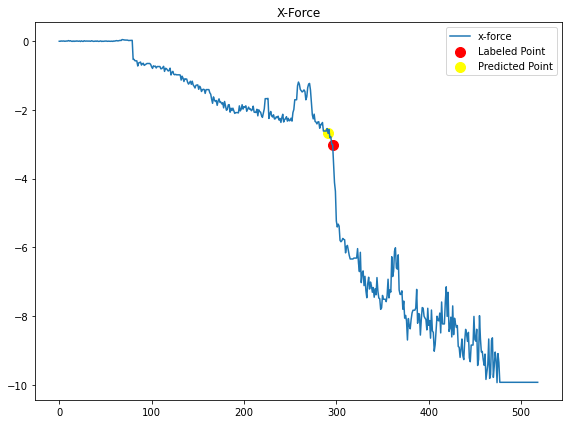

##################### NEXT #####################


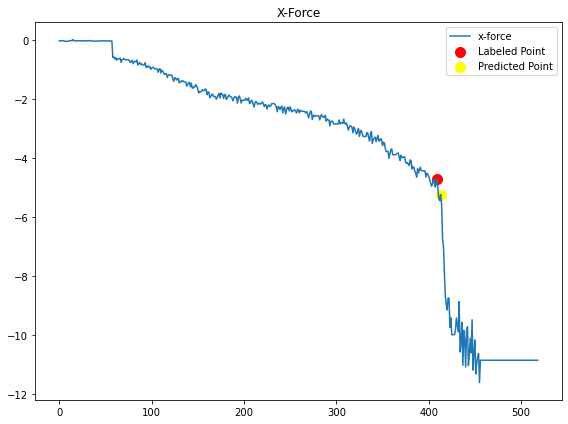

##################### NEXT #####################


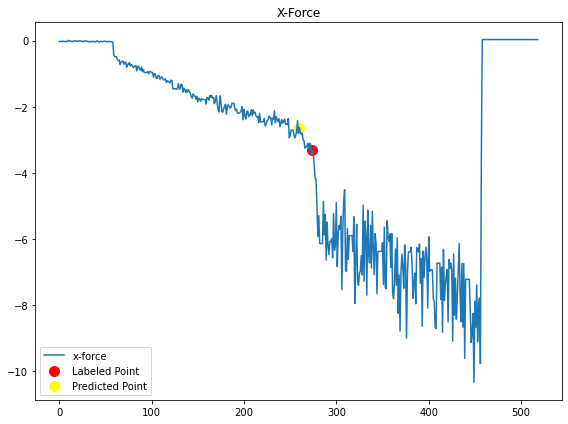

##################### NEXT #####################


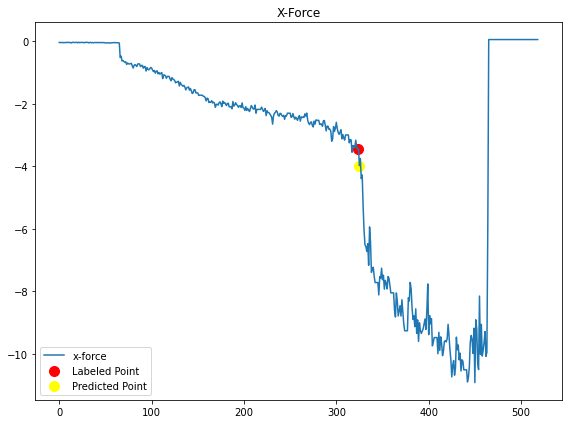

##################### NEXT #####################


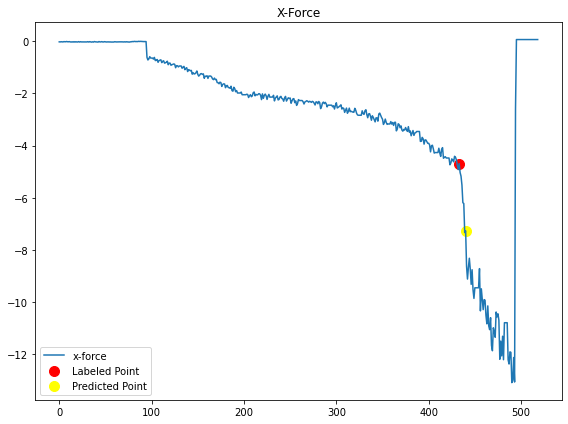

##################### NEXT #####################


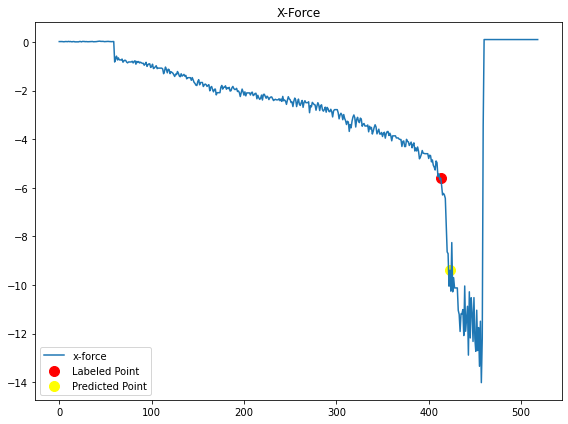

##################### NEXT #####################


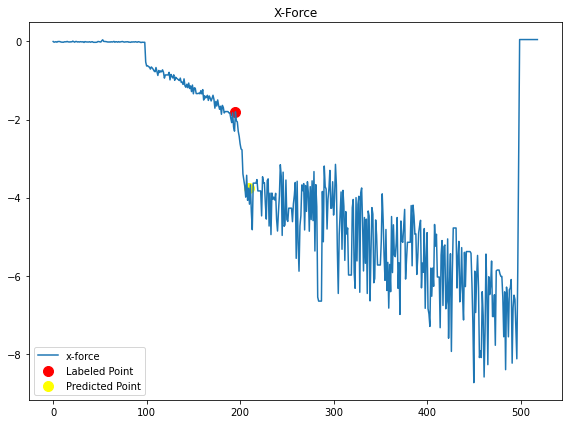

##################### NEXT #####################


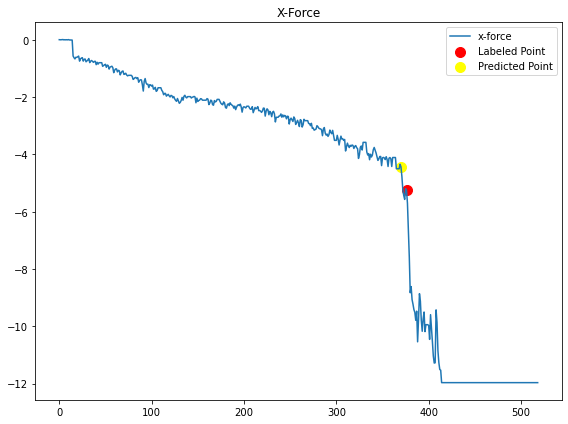

##################### NEXT #####################


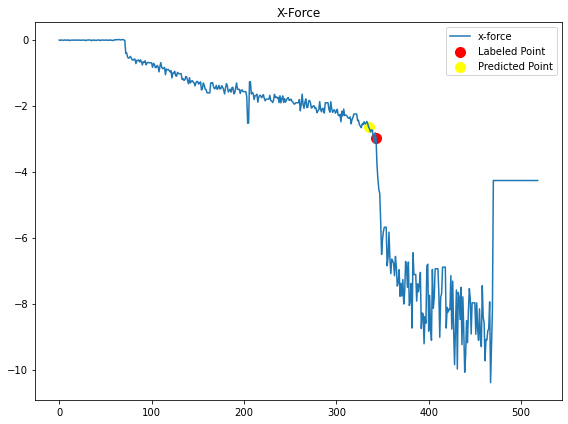

##################### NEXT #####################


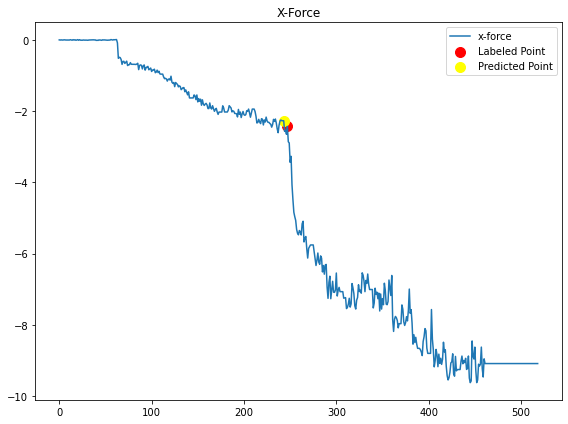

##################### NEXT #####################


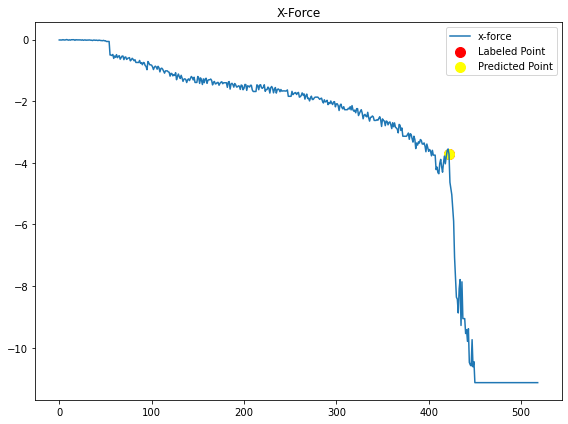

##################### NEXT #####################


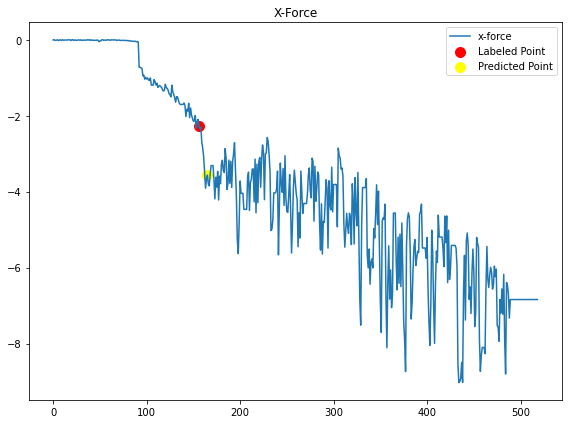

##################### NEXT #####################


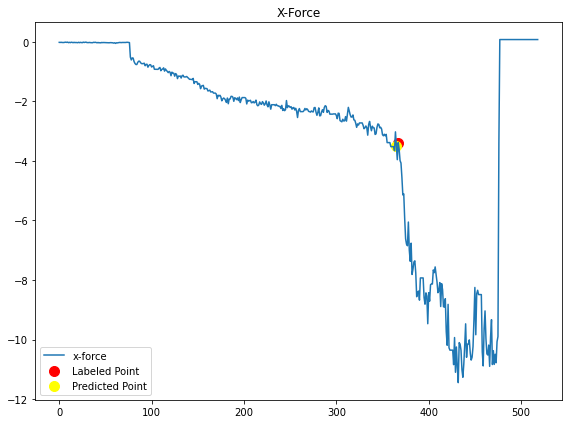

##################### NEXT #####################


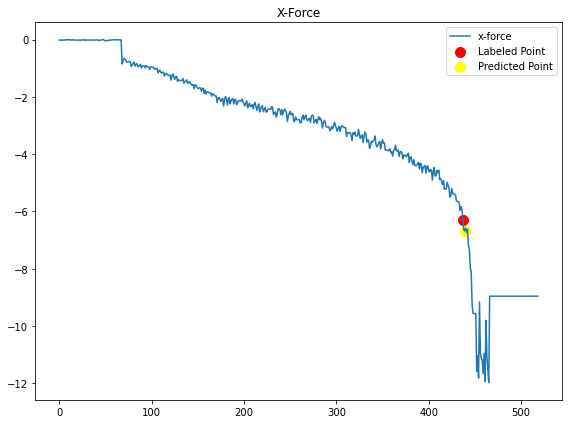

##################### NEXT #####################


In [21]:
# Predict
predictions = best_model.predict(X_test)
predictions = np.round(predictions)
# Print the arrays side by side
# for a, b in zip(predictions, np.round(y_test)):
#     print(f"{int(a)} {b}")
for i, item in enumerate(predictions):
    x_force = X_test[i][:, 0]
    label = y_test[i]
    item = int(item[0])

    plt.figure(figsize=(8, 6))

    plt.plot(np.arange(len(x_force)), x_force, label='x-force')
    plt.scatter(label, x_force[label], color='red', label='Labeled Point', s=100)
    plt.scatter(item, x_force[item], color='yellow', label='Predicted Point', s=100)
    
    plt.title('X-Force')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("##################### NEXT #####################")

# Classification

In [22]:
csv = pd.read_csv('./pda_2023-04-18_10-13-22.csv', skiprows = 7)
csv['Zeit'] =  pd.to_datetime(csv['Zeit'])
csv.sort_values(by='Zeit', inplace = True)

labels = pd.read_csv('./labels_030723.csv')
labels = labels[labels['row'] != 'Aussortieren']
print(len(labels))

df = csv[['Zeit','product_id', 'run_id', 'experiment_id', 'trial_id', 'set_force_begin',
       'x_position', 'y_position', 'z1_position', 'z2_position', 'x_velocity',
       'y_velocity', 'z1_velocity', 'z2_velocity', 'x_force', 'y_force',
       'z_force']]
df = df[df["product_id"] == 304]
good_experiment_ids = [{"run_id": 0, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
                  {"run_id": 1, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
                  {"run_id": 2, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
                  {"run_id": 3, "experiment_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}
                ]
peak_dfs = []
for item in good_experiment_ids:
    df_temp = df[df["run_id"] == item["run_id"]]
    for item2 in item["experiment_ids"]:
        df_temp2 = df_temp[df_temp["experiment_id"] == item2]
        liste_temp = df_temp2["trial_id"].unique()
        for item3 in liste_temp:
            #print(item["run_id"], item2, item3 )
            if labels[(labels['trial_id'] == item3) & (labels['experiment_id'] == item2) & (labels['run_id'] == item["run_id"])].shape[0] > 0:
                peak_df = df_temp2[df_temp2["trial_id"] == item3]
                peak_dfs.append(peak_df[["run_id", "trial_id", "experiment_id", 'x_position', 'x_force', 'y_force', 'z_force']])
            
print(len(peak_dfs))

filtered_peak_dfs = []

for i, item in enumerate(peak_dfs):
    filtered_df_temp = item[item['x_position'] > 20.0001].reset_index(drop=True)
    
    peak_row_temp = filtered_df_temp['x_position'].idxmax()
    
    peak_row_data_temp = filtered_df_temp.loc[:peak_row_temp-1]
    
    filtered_df_temp2 = filtered_df_temp.loc[peak_row_temp:]
    
    condition = filtered_df_temp2['x_force'] >= 0
    
    extracted_rows = filtered_df_temp2.loc[:condition.idxmax()]
        
    if (extracted_rows['x_position'] >= 99.9).all():
        filtered_peak_dfs.append(pd.concat([peak_row_data_temp, extracted_rows]))
    else:
        filtered_peak_dfs.append(peak_row_data_temp)
print(len(filtered_peak_dfs))

max_length = max(len(df) for df in filtered_peak_dfs)

padded_dataframes = []
for df in filtered_peak_dfs:
    padding_size = 519 - len(df) #padding_size - len(df) # check classification
    padded_df = pd.DataFrame(np.pad(df.values, ((0, padding_size), (0, 0)), mode='edge'), columns=df.columns)
    padded_df['index'] = padded_df.index
    padded_dataframes.append(padded_df)
print(len(padded_dataframes))

lengths = set()
polke_padded_dataframes_with_labels = []
for item in padded_dataframes:
    lengths.add(len(item))
    
    run_id = item["run_id"].unique()[0],
    trial_id = item["trial_id"].unique()[0],
    experiment_id = item["experiment_id"].unique()[0]
    
    #print("RUN_ID:", run_id,"experiment_id:",  experiment_id,"trial_id:", trial_id)

    indidvidual = labels[labels["run_id"] == run_id]
    indidvidual = indidvidual[indidvidual["experiment_id"] == experiment_id]
    indidvidual = indidvidual[indidvidual["trial_id"] == trial_id]
    

    polke_padded_dataframes_with_labels.append((item, row_value))

print(lengths)

398
398
398
398
{519}


In [23]:
X, y = [], []

for i,item in enumerate(polke_padded_dataframes_with_labels):
    Peak_df = item[0]
    run_id = int(Peak_df["run_id"].unique()[0]),
    trial_id = int(Peak_df["trial_id"].unique()[0]),
    experiment_id = int(Peak_df["experiment_id"].unique()[0])
    
    
    indidvidual = labels[labels["run_id"] == run_id]
    indidvidual = indidvidual[indidvidual["experiment_id"] == experiment_id]
    indidvidual = indidvidual[indidvidual["trial_id"] == trial_id]

    X.append(Peak_df)
    y.append(indidvidual["row"].iloc[0])
    
print(len(padded_dataframes))
print(len(X))
print(len(y))

tensor_X = []
for item in X:
    #item = item[['x_force', 'y_force', 'z_force']].copy()
    item = item[['x_force']].copy()
    a = item.to_numpy().astype(np.float32)
    tensor_X.append(a)
    
y_class = np.where(np.array(y) == 'None', 0, 1).astype(int)
print(np.bincount(y_class))
y_class

398
398
398
[143 255]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [24]:
X_train, X_test, y_train, y_test = train_test_split(np.array(tensor_X), y_class, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Check the class distribution in the train and test sets
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)

print("Train class distribution:")
print(train_class_counts)

print("\nTest class distribution:")
print(test_class_counts)

(318, 519, 1) (80, 519, 1)
(318,) (80,)
Train class distribution:
[110 208]

Test class distribution:
[33 47]


In [25]:
# Define the model architecture
# Define the model architecture
model = Sequential()
kernel_size = 4

# Add normalization layer
model.add(BatchNormalization(input_shape=(X_train.shape[1], 1)))

model.add(Conv1D(8, kernel_size=kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(16, kernel_size=kernel_size*2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, kernel_size=kernel_size*4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# Adjust the learning rate
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy loss

In [26]:
pip install pydot

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Note: you may need to restart the kernel to use updated packages.


In [27]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'Polke_only_Classification_best_model.h5',              # Filepath to save the model
    monitor='val_loss',           # Metric to monitor
    save_best_only=True,          # Save only the best model
    save_weights_only=False,      # Save the entire model (including architecture)
    mode='min',                   # 'min' or 'max' depending on the monitored metric
    verbose=1                      # Print messages about saving progress
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.7799
Epoch 1: val_loss improved from inf to -4437.99902, saving model to Polke_only_Classification_best_model.h5
20/20 [==============================] - 2s 31ms/step - loss: 0.4798 - accuracy: 0.7799 - val_loss: -4437.9990 - val_accuracy: 0.0000e+00
Epoch 2/200
17/20 [========================>.....] - ETA: 0s - loss: 0.2974 - accuracy: 0.8897
Epoch 2: val_loss did not improve from -4437.99902
20/20 [==============================] - 0s 18ms/step - loss: 0.2926 - accuracy: 0.8899 - val_loss: -3732.9023 - val_accuracy: 0.0000e+00
Epoch 3/200
17/20 [========================>.....] - ETA: 0s - loss: 0.2081 - accuracy: 0.9191
Epoch 3: val_loss improved from -4437.99902 to -4857.23926, saving model to Polke_only_Classification_best_model.h5
20/20 [==============================] - 0s 21ms/step - loss: 0.1868 - accuracy: 0.9308 - val_loss: -4857.2393 - val_accuracy: 0.0000e+00
Epoch 4/200
17/20 [=======

18/20 [==========================>...] - ETA: 0s - loss: 0.0178 - accuracy: 0.9965
Epoch 29: val_loss did not improve from -10250.95020
20/20 [==============================] - 0s 16ms/step - loss: 0.0163 - accuracy: 0.9969 - val_loss: -3952.2766 - val_accuracy: 0.0000e+00
Epoch 30/200
18/20 [==========================>...] - ETA: 0s - loss: 0.0125 - accuracy: 0.9965
Epoch 30: val_loss did not improve from -10250.95020
20/20 [==============================] - 0s 16ms/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: -3064.0298 - val_accuracy: 0.0000e+00
Epoch 31/200
17/20 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000
Epoch 31: val_loss did not improve from -10250.95020
20/20 [==============================] - 0s 16ms/step - loss: 0.0081 - accuracy: 0.9969 - val_loss: -7482.9180 - val_accuracy: 0.0000e+00
Epoch 32/200
17/20 [========================>.....] - ETA: 0s - loss: 0.0832 - accuracy: 0.9853
Epoch 32: val_loss did not improve from -10250.95020
20/

18/20 [==========================>...] - ETA: 0s - loss: 8.4587e-05 - accuracy: 1.0000
Epoch 57: val_loss did not improve from -10250.95020
20/20 [==============================] - 0s 16ms/step - loss: 7.6846e-05 - accuracy: 1.0000 - val_loss: -9034.3145 - val_accuracy: 0.0000e+00
Epoch 58/200
17/20 [========================>.....] - ETA: 0s - loss: 6.0046e-04 - accuracy: 1.0000
Epoch 58: val_loss did not improve from -10250.95020
20/20 [==============================] - 0s 16ms/step - loss: 5.2383e-04 - accuracy: 1.0000 - val_loss: -7509.5664 - val_accuracy: 0.0000e+00
Epoch 59/200
17/20 [========================>.....] - ETA: 0s - loss: 2.0017e-04 - accuracy: 1.0000
Epoch 59: val_loss did not improve from -10250.95020
20/20 [==============================] - 0s 18ms/step - loss: 3.5363e-04 - accuracy: 1.0000 - val_loss: -7909.7930 - val_accuracy: 0.0000e+00
Epoch 60/200
18/20 [==========================>...] - ETA: 0s - loss: 5.5178e-05 - accuracy: 1.0000
Epoch 60: val_loss did not i

20/20 [==============================] - 0s 21ms/step - loss: 9.0418e-06 - accuracy: 1.0000 - val_loss: -10436.6191 - val_accuracy: 0.0000e+00
Epoch 85/200
18/20 [==========================>...] - ETA: 0s - loss: 5.2274e-06 - accuracy: 1.0000
Epoch 85: val_loss improved from -10436.61914 to -10501.18262, saving model to Polke_only_Classification_best_model.h5
20/20 [==============================] - 0s 20ms/step - loss: 1.8612e-05 - accuracy: 1.0000 - val_loss: -10501.1826 - val_accuracy: 0.0000e+00
Epoch 86/200
18/20 [==========================>...] - ETA: 0s - loss: 4.2005e-05 - accuracy: 1.0000
Epoch 86: val_loss improved from -10501.18262 to -10622.27441, saving model to Polke_only_Classification_best_model.h5
20/20 [==============================] - 0s 19ms/step - loss: 3.8526e-05 - accuracy: 1.0000 - val_loss: -10622.2744 - val_accuracy: 0.0000e+00
Epoch 87/200
19/20 [===========================>..] - ETA: 0s - loss: 1.1780e-05 - accuracy: 1.0000
Epoch 87: val_loss improved from 

Epoch 111/200
17/20 [========================>.....] - ETA: 0s - loss: 0.0298 - accuracy: 0.9890
Epoch 111: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 17ms/step - loss: 0.0309 - accuracy: 0.9874 - val_loss: -3950.0259 - val_accuracy: 0.0000e+00
Epoch 112/200
17/20 [========================>.....] - ETA: 0s - loss: 0.0313 - accuracy: 0.9890
Epoch 112: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 0.0290 - accuracy: 0.9906 - val_loss: -3470.8750 - val_accuracy: 0.0000e+00
Epoch 113/200
17/20 [========================>.....] - ETA: 0s - loss: 0.0380 - accuracy: 0.9853
Epoch 113: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 0.0368 - accuracy: 0.9843 - val_loss: -4680.3135 - val_accuracy: 0.0000e+00
Epoch 114/200
17/20 [========================>.....] - ETA: 0s - loss: 0.0214 - accuracy: 0.9890
Epoch 114: val_loss did not improve 

18/20 [==========================>...] - ETA: 0s - loss: 3.3292e-05 - accuracy: 1.0000
Epoch 139: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 3.0193e-05 - accuracy: 1.0000 - val_loss: -9145.1113 - val_accuracy: 0.0000e+00
Epoch 140/200
17/20 [========================>.....] - ETA: 0s - loss: 5.7062e-05 - accuracy: 1.0000
Epoch 140: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 4.9007e-05 - accuracy: 1.0000 - val_loss: -9586.0518 - val_accuracy: 0.0000e+00
Epoch 141/200
17/20 [========================>.....] - ETA: 0s - loss: 3.9742e-05 - accuracy: 1.0000
Epoch 141: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 3.4200e-05 - accuracy: 1.0000 - val_loss: -10074.2109 - val_accuracy: 0.0000e+00
Epoch 142/200
17/20 [========================>.....] - ETA: 0s - loss: 6.5066e-06 - accuracy: 1.0000
Epoch 142: val_loss d

Epoch 167/200
17/20 [========================>.....] - ETA: 0s - loss: 1.0331e-04 - accuracy: 1.0000
Epoch 167: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 9.3457e-05 - accuracy: 1.0000 - val_loss: -9906.1328 - val_accuracy: 0.0000e+00
Epoch 168/200
17/20 [========================>.....] - ETA: 0s - loss: 4.3989e-05 - accuracy: 1.0000
Epoch 168: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 17ms/step - loss: 3.9795e-05 - accuracy: 1.0000 - val_loss: -9961.5029 - val_accuracy: 0.0000e+00
Epoch 169/200
18/20 [==========================>...] - ETA: 0s - loss: 7.2419e-05 - accuracy: 1.0000
Epoch 169: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 6.5755e-05 - accuracy: 1.0000 - val_loss: -10136.2773 - val_accuracy: 0.0000e+00
Epoch 170/200
18/20 [==========================>...] - ETA: 0s - loss: 7.2041e-05 - accuracy: 1.0000
Epoch 1

Epoch 195/200
18/20 [==========================>...] - ETA: 0s - loss: 7.5710e-04 - accuracy: 1.0000
Epoch 195: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 7.3205e-04 - accuracy: 1.0000 - val_loss: -8909.5244 - val_accuracy: 0.0000e+00
Epoch 196/200
17/20 [========================>.....] - ETA: 0s - loss: 4.3587e-04 - accuracy: 1.0000
Epoch 196: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 17ms/step - loss: 3.8900e-04 - accuracy: 1.0000 - val_loss: -10933.3838 - val_accuracy: 0.0000e+00
Epoch 197/200
17/20 [========================>.....] - ETA: 0s - loss: 7.3332e-04 - accuracy: 1.0000
Epoch 197: val_loss did not improve from -18606.48828
20/20 [==============================] - 0s 16ms/step - loss: 6.4567e-04 - accuracy: 1.0000 - val_loss: -14558.1748 - val_accuracy: 0.0000e+00
Epoch 198/200
17/20 [========================>.....] - ETA: 0s - loss: 8.3760e-05 - accuracy: 1.0000
Epoch 

In [29]:
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.3919 - accuracy: 0.9625


[0.3919394910335541, 0.9624999761581421]

In [30]:
y_pred = model.predict(np.array(tensor_X))
model.evaluate(np.array(tensor_X), y_class)

13/13 [==============================] - 0s 8ms/step - loss: 0.0792 - accuracy: 0.9925


[0.07916717231273651, 0.9924623370170593]

In [31]:
# helper functions
# 1. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, threshold=0.5):
    y_pred_binary = np.where(y_pred >= threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred_binary)
    fig = ff.create_annotated_heatmap(z=cm, x=classes, y=classes)
    fig.update_layout(title='Confusion Matrix',
                      xaxis=dict(title='Predicted Label'),
                      yaxis=dict(title='True Label'))
    fig.show()
y_pred_binary = np.where(np.squeeze(y_pred) >= 0.5, 1, 0)
misclassified_indices = np.where(y_class != y_pred_binary)[0]
plot_confusion_matrix(y_class, y_pred, classes=['None', 'Kratzer'], threshold=0.5)

In [32]:
for i in misclassified_indices:
    print(i)
    df = X[i]
    print( f"RUN_ID: {df['run_id'][0]}, TRIAL_ID: {df['trial_id'][0]}, EXP_ID: {df['experiment_id'][0]}")
    
    
    fig = go.Figure(data=go.Scatter(x=df['index'], y=df["x_force"].to_numpy().flatten(), mode='lines'))
    
    additional_text = f"TRUE: {int(y_class[i])}, PRED: {y_pred_binary[i]}"
    run_id = df["run_id"].unique()[0],
    trial_id = df["trial_id"].unique()[0],
    experiment_id = df["experiment_id"].unique()[0]
    
    
    indidvidual = labels[labels["run_id"] == run_id]
    indidvidual = indidvidual[indidvidual["experiment_id"] == experiment_id]
    indidvidual = indidvidual[indidvidual["trial_id"] == trial_id]
    
    # Get the row value from the 'individual' DataFrame
    if indidvidual['row'].iloc[0].isnumeric():
        row_value = int(indidvidual['row'])
        print("ROW VALUE: ", row_value)
    else:
        print("NONE")
        continue
    
    text_trace = go.Scatter(x=[300], y=[-12], mode='text', text=[additional_text], name='Additional Info',
                        textposition='bottom center')
        
    clicked_point = go.Scatter(
    x=np.array(int(indidvidual["row"])),
    y=np.array(df.iloc[int(indidvidual["row"])]['x_force']),
    mode='markers',
    marker=dict(
        symbol='x',
        size=10,
        color='red'))

    
    # Add the text trace to the figure
    fig.add_trace(text_trace)
    fig.add_trace(clicked_point)
    fig.show()

349
RUN_ID: 3.0, TRIAL_ID: 1.0, EXP_ID: 5.0
NONE
350
RUN_ID: 3.0, TRIAL_ID: 2.0, EXP_ID: 5.0
NONE
354
RUN_ID: 3.0, TRIAL_ID: 6.0, EXP_ID: 5.0
NONE
